# Basic drift detection and characterization
This tutorial shows how to implement a basic form of drift characterization on time-stamped data. This data can be from almost any quantum-circuit based experiment on one or more qubits, including suitably time-ordered GST or RB experiments. The methods in this notebook can be used on data from any experiment that satisfies the following criteria: 

- The experiments consist of $S \geq 1$ different circuits, or sequences, acting on $Q \geq 1$ entitities, where each entity is most likely a single qubit. (Each entity could correspond to, say, 2 qubits, but the most likely use for these methods is where each entity is a single qubit. So, for clarity, in this tutorial will just refer to these entitities as qubits).


- Sequence $s$ is repeated, and an outcome recorded, $N$ times during each of $T$ different time-intervals. Let $\tau_{s,1},\tau_{s,2},\dots,\tau_{s,T}$ denote times associated with these time-intervals (e.g., the start time or mid-point of each interval).


- The time-gap between consecutive sets of $N$ repeats of a sequence is approximately constant, and approximately independent of sequence. That is $t_{s,gap} \approx \tau_{s,t+1} - \tau_{s,t}$ for all $s,t$ and some constant $t_{s,gap}$ (the time gap is constant for each sequence), and $t_{gap} \equiv t_{s,gap} \approx t_{s',gap}$ for all $s,s'$ (the time gap is the same for every sequence).


- The result of each circuit has two possible outcomes for each qubit. Equivalently, the result of one repeat of a circuit can be represented as a bit string of length $Q$, where the $q^{\rm th}$ bit represents the outcome for qubit $q$.

Many characterization routines, include GST or RB, satisfy the above criteria *if* a suitable time-ordering for the repeats of all of the sequences is chosen. 

#### An example of a suitable experiment

To clarify the above criteria, we now provide an example of a suitable experiment. One such suitable experiment would be 1 or 2 qubit GST. GST consists of implementing $S$ different sequences, and each sequence is repeated -- in total -- $R$ times. This set of experiments could be implemented by implementing sequences $1,2,...,S$ in order, each repeated $N$ times, with this complete loop of $S$ sequences repeated $T$ times, with $R = N \times T$. As long as the there are no significant unexpected wait-times between any sequences (e.g., the experiment is not stopped for a significant length of time at some point), this experiments will satisfy the time-spacing criteria given above.

#### What is the aim of the methods in this tutorial?

The analysis function presented in this tutorial has two purposes: to detect and characterize drift. To be more specific, ....

$$ \boldsymbol{p}_{s} = (p_{s,1},p_{s,2},\dots,p_{s,Q})$$.

However, ....

#### How do the methods in this tutorial work?

The drift detection works via spectral analysis, by implement a type of discrete Fourier transform on the data and looking for peaks in the power spectrum that are larger than would be expected if there was no drift. This is detailed below in section 2.

#### What are acceptable and optimal values for $N$, $T$, $S$?

The total number of experiments is $N * T * S$, and for a fixed number of total experiments ... For fixed $N * T$, $N=1$ is alway the best option in principle (but note that the basic .....). However, if $T$ cannot be scaled as $1/N$ (e.g., because it is quicker to repeat the same sequence), it is not clear how best .... .

#### What not to expect from this tutorial

- This tutorial does *not* provide specifications for what experiments to run to detect and characterize drift. One option is the GST sequences, but this is not the only option, and it will not always be the best option. Suggested experiments will be included in a future tutorial or examples notebook.


- The methods in this tutorial can detect and partially characterize drift, but they cannot certify that a device does not have drift. For example, if $N * T$ is very small (say, 50) then, unless the drift is "large", it is very likely that no drift will be detected, but obviously that does not mean that the device is drift free; the drift is just undetectable without taking more data.


- The analysis function demonstrated in this tutorial been designed for ...

In [31]:
# No special imports are required, beyond pygsti
from __future__ import print_function
import pygsti

# Imported for plotting output from the examples, and generate data.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# To access some simulation functions, we import the drift module. This is not needed to run the analysis on real data
from pygsti import drift


For the purposes of this demonstration, we will take $S$, $Q$, $T$ and $N$ to be:

In [4]:
S = 3 #The number of different sequences
Q = 2 #The number of qubits
T = 100 #The number of timestamps
N = 5 #The number of repeats per timestamps

#### Generating fake data
We need some fake data to demonstrate the methods. 

One natural method for generating this data is to pick some time-dependent function for the underlying drifting probabilities associated with each sequence and each qubit -- which are what we are trying to characterize -- and then sample from these probabilities to generate some data. This is what we'll do below.
 
Below, we set the target probability of all the circuits, and plot them. There exact forms are not particularly relevant to this tutorial, and have been chosen fairly arbitrarily.

In [6]:
lag_time = 1e-6
sequence_time = 1e-9
# ....
tmax = lag_time*T

# Probability ....
def probs0q0(t): return 0.5
def probs0q1(t): return 0.5
def probs1q0(t): return 0.5+0.008*np.cos((t+1/2.)*(T-5)*np.pi/tmax) + 0.05*np.sin(t*0.9*np.pi/tmax) - 0.1*np.cos(t*2.48*np.pi/tmax) 
def probs1q1(t): return 0.5+0.08*np.cos((t+1/2.)*(T-5)*np.pi/tmax)
def probs2q0(t): return 0.5+0.016*np.cos((t+1/2.)*(T-5)*np.pi/tmax) + 0.2*np.sin(t*0.9*np.pi/tmax) - 0.2*np.cos(t*2.48*np.pi/tmax) 
def probs2q1(t): return 0.5+0.3*np.cos((t+1/2.)*(T-5)*np.pi/tmax)

prob = {}
prob[0,0] = probs0q0
prob[0,1] = probs0q1
prob[1,0] = probs1q0
prob[1,1] = probs1q1
prob[2,0] = probs2q0
prob[2,1] = probs2q1

sample_times = np.zeros((S,T*N),float)
for s in range(0,S):
    for t in range(0,T):
        for n in range(0,N):
            sample_times[s,t*N +n] = sequence_time*(N*s+n) + t*lag_time

This function samples fake data, from some specified ...

In [7]:
data, times, parray = drift.generate_drifting_data(prob,sample_times,coursegrain=N)

In [26]:
timestep = 1e-6
confidence = 0.95

In [27]:
results = pygsti.do_basic_drift_characterization(data, N, timestep=timestep, confidence=confidence)

In [28]:
results.drift_detected

True

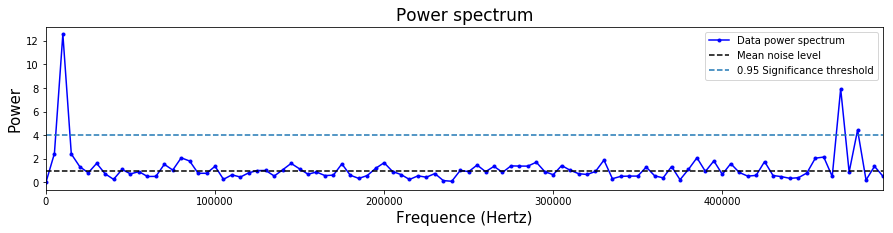

In [29]:
results.plot_power_spectrum()

In [36]:
print("Drift has been detected at the following frequencies, given in Hertz:")
print(results.global_drift_frequencies)

Drift has been detected at the following frequencies, given in Hertz:
[  10000.  470000.  480000.]


## 2. Looking under the hood part 1: what kind of data are we analyzing?

## 1. Input data format

The techniques do not require any particular type of gate sequences, nor do they need to know what the gate sequences are. In particular, they do not require GST data. As such, the format for the main input data is not a pyGSTi dataset, and is instead an ordinary numpy array (later, functionality to accept a form of pyGSTi dataset as input will be addded).

The input data format is a numpy array $M$ of dimension $(S \times Q \times T)$, where
$M[s,q,t]$ is the number of counts for qubit $q$, with sequence $s$, for the $t^{\rm th}$ implementation of that sequence. 

** Talk about the marginalized thing here ** E.g., 4 outcomes with ....

In the special case of $Q = 1$, the array can be either of dimension $(S \times 1 \times T)$ or $(S \times T)$, to avoid requiring the data to be padded with an unnecessary dimension.



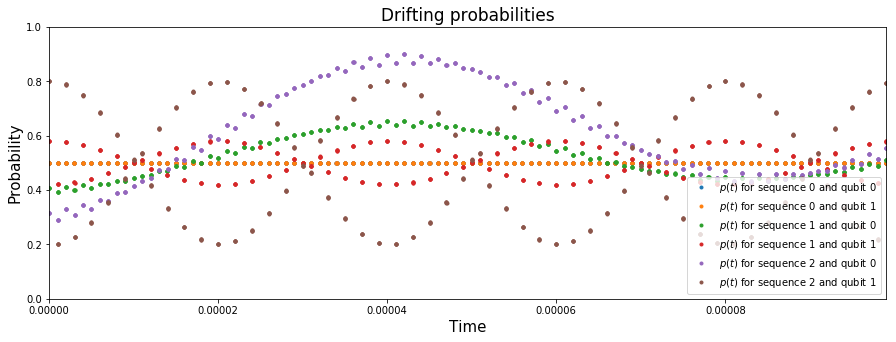

In [8]:
fig=plt.figure(figsize=(15,5))

# We create some drifting probabilities, with sinosodial osscilating around a mean of 0.5,
# with the drift strength and frequencies varying between sequence (increasing with sequence
# index) and between qubit.
linestyle = {}
linestyle[0] = '-'
linestyle[1] = '.--'
for s in range(0,S):
    for q in range(0,Q):
        string = '$p(t)$ for sequence '+str(s)+' and qubit '+str(q)
        #plt.plot(np.linspace(),[prob[s,q](t) for t in sample_times[s,:]],linestyle[q],label=string)
        plt.plot(sample_times[s,:],[prob[s,q](t) for t in sample_times[s,:]],'.',label=string)
        
plt.legend(loc='lower right'); plt.xlim(0,np.max(sample_times)); plt.ylim(0,1)
plt.title("Drifting probabilities",fontsize=17)
plt.xlabel("Time",fontsize=15)
plt.ylabel("Probability",fontsize=15)
plt.show()

From these drifting probabilities, we can now sample some data, to simulate an experiment in which the underlying probabilities drifted as specified above. Below, this data is plotted for one of the sequence-qubit pairs with significant drift.

It is probably not obvious, from simply looking at this data, whether it is likely consistent with standard fluctations due to measurement outcome randomness, or whether there are clear signs that the underlying probability is drifting. This is what the analysis attempts to deduce.

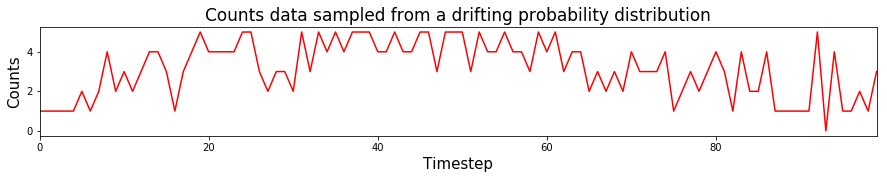

In [9]:
qubit = 0
sequence = 2
plt.figure(figsize=(15,2))
plt.plot(data[sequence,qubit,:],'r-',label=string)

plt.title("Counts data sampled from a drifting probability distribution",fontsize=17)
plt.xlabel("Timestep",fontsize=15)
plt.ylabel("Counts",fontsize=15)
plt.xlim(0,T-1)
plt.show()

## 2. Looking under the hood part 2: what are the analysis methods?

Some explanation of the method

Be very explicit about what the math is.

In [10]:
qubit = 1
sequence = 2
confidence = 0.99

In [11]:
# This 
from pygsti import drift
from scipy.stats import chi2

#pt_power_spectrum = drift.DCT(N*prob[sequence,qubit,:],counts=N)**2
data_power_spectrum = drift.DCT(data[sequence,qubit,:],counts=N)**2

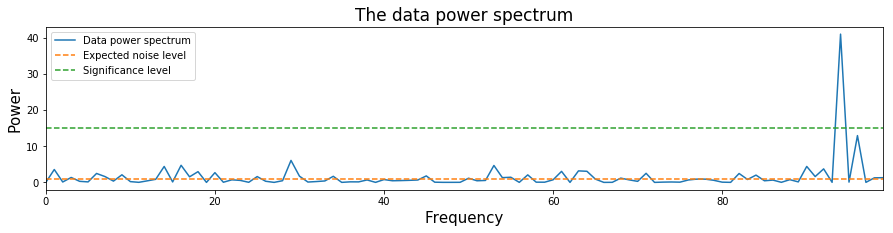

In [12]:
plt.figure(figsize=(15,3))
#plt.plot(pt_power_spectrum,'-',label='$p(t)$ power spectrum')
plt.plot(data_power_spectrum,'-',label='Data power spectrum')
plt.plot(np.ones(T),'--',label='Expected noise level')
plt.plot(chi2.isf(1-confidence**(1/T),1)*np.ones(T),'--',label='Significance level')

plt.legend()
plt.xlim(0,T-1)
plt.title("The data power spectrum",fontsize=17)
plt.xlabel("Frequency",fontsize=15)
plt.ylabel("Power",fontsize=15)
plt.show()

## 3. Analysing time-stamped data
To analysis the data, we use the `pygsti.do_basic_drift_characterization()` function. This function takes two non-optional arguments:
- The data, as an ordinary numpy array of dimension $(S \times Q \times T)$ (or optionally as an $(S \times T)$ for the case of $Q=1$), consisting of measurement outcome counts. This has already been detailed above.


- The number of counts per timestep, $N$. This has to be specified, because it is not possible to reliably extract this from the data array (even though it will often correspond to the maximum value in the data array).

It also takes some optional arguments. There are two important arguments of this sort:

- `timestep`. This is the size of the gap between each set of $N$ repeats of each sequence. It should be specified in seconds. If it is specified, then the drift frequencies returned by this function are in Hertz. If it is not specified then the drift frequencies are integers between 0 and $T-1$, corresponding to the index of the DCT frequency (i.e., $1$ is the fundamental frequency, etc).


- `confidence`. This is the confidence of the hypothesis tests used to detect drift, and reconstruct estimates of the $p(t)$. More details of what this corresponds to are given later. The default value is 0.95.

True

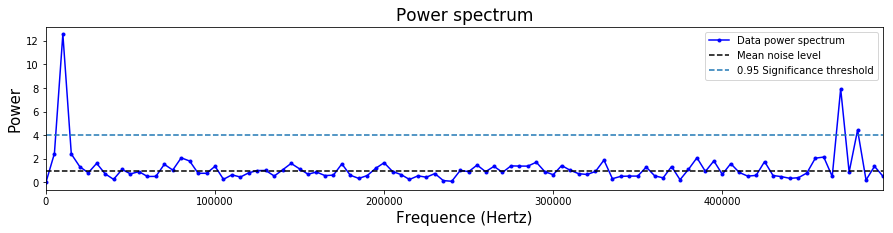

In [25]:
print(results.global_drift_frequencies)

[  10000.  470000.  480000.]


In [17]:
results.pspq_pvalue[:,0]

array([  7.35769277e-01,   1.90432398e-01,   1.11022302e-14])

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  1.56371470e-08,   9.48947218e-02,   1.89789428e-01,
          2.84684134e-01,   3.79578840e-01,   4.74473546e-01,
          5.69368252e-01,   6.64262958e-01,   7.59157665e-01,
          8.54052371e-01,   9.48947077e-01]),
 <a list of 10 Patch objects>)

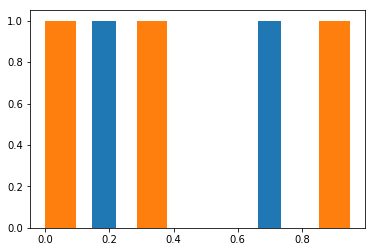

In [18]:
plt.hist(results.pspq_pvalue[:,0])
plt.hist(results.pspq_pvalue[:,1])

In [19]:
results.global_pvalue

3.141931159689193e-12

In [20]:
results.global_max_power

12.570328391556098

In [21]:
results.pq_pvalue

array([  1.22124533e-13,   3.70597990e-08])

In [22]:
results.pspq_pvalue

array([[  7.35769277e-01,   9.48947077e-01],
       [  1.90432398e-01,   3.23186659e-01],
       [  1.11022302e-14,   1.56371470e-08]])

In [23]:
x = 20
plt.plot([ (1-_chi2.sf(y,x)/x) for y in np.linspace(0,10,100)])

NameError: name '_chi2' is not defined

In [ ]:
results.global_pvalue

In [ ]:
results.pq_pvalue

In [ ]:
results.pspq_pvalue

In [ ]:
results.pspq_drift_detected

In [ ]:
results.global_significance_threshold

In [ ]:
results.pspq_significance_threshold

In [ ]:
results.pq_significance_threshold

In [ ]:
results.drift_detected

We have now successfully run the analysis! 

## 4. Exploring the output

Let's look at the output. The function returns a `BasicDriftResults` object, which is essential just a container for a range of output created by the analysis. 
1. All properties starting with `.individual` are related to individual drift detection/characterization analysises of the data from each sequence and qubit. 
2. All properties starting with `.global` are ....
3. All other properties of ...are ...

### 4.1 Was drift detected?
The property of results is the `.all_detected` truth value. This ....

CAN NAME TO ANY DETECTED

### 4.2 What frequencies can we dectect drift at?
The drift ....


In [ ]:
print(results.frequencies)

In [ ]:
print(results.global_drift_frequencies)

# This seems to be a mistake.
#
#
# Put the global and superglobal
#

In [ ]:
# .perqubit
# .perqubit_persequence

In [ ]:
#
# Todo: mean noise level in plots.
#

### 4.3 The averaged power spectrums

add in the p(t) vector power spectrum

In [ ]:
max_power = 0
for q in range(0,Q):
    max_power = max(max_power,np.max(results.pq_power_spectrum[q]))

for q in range(0,Q):
    plt.figure(figsize=(15,2.5))
    plt.plot(results.frequencies,results.pq_power_spectrum[q],'r.-',label='Spectrum')
    plt.plot(results.frequencies,results.pq_significance_threshold*np.ones(T),'b-',label='Significance threshold')
    plt.title("Averaged power spectrum for qubit {}".format(q),fontsize=17)
    plt.xlabel("Frequency (Hz)",fontsize=15)
    plt.ylabel("Power",fontsize=15)
    #plt.ylim(0,max_power)
    plt.xlim(0,max(results.frequencies))
    plt.legend()
    plt.show()

### 4.4 Analysis for individual sequences

In [ ]:
qubit = 1
sequence = 2

#### The power spectrum for a particular sequence and qubit

In [ ]:
plt.figure(figsize=(15,2.5))
plt.plot(results.frequencies,results.individual_power_spectrum[sequence,qubit,:],'r.-',label='Spectrum')
plt.plot(results.frequencies,results.individual_max_power_threshold*np.ones(T),'b-',label='Significance threshold')
plt.title("....".format(q),fontsize=17)
plt.xlabel("Frequency (Hz)",fontsize=15)
plt.ylabel("Power",fontsize=15)
plt.xlim(0,max(results.frequencies))
plt.legend()
plt.show()

#### Significant frequencies for a particular sequence and qubit

In [ ]:
print(results.individual_drift_frequencies[sequence,qubit])

#### The p-value for detecting drift
.....
.
Todo: rename the pvalues without max_power in them.

In [ ]:
results.individual_max_power_pvalues[sequence,qubit]

In [ ]:
results.pspq_pvalue

below this should be a barchart (and make integers on the axis!).

plot inverse pvalue, and put threshold for 0.95 confidence

In [ ]:
plt.figure(figsize=(6,3))
for q in range(0,Q):
    plt.plot(results.pspq_pvalue[:,q],'o-',label='qubit '+str(q))
plt.yscale("log")
plt.legend()
plt.ylabel("p-value",fontsize=15)
plt.xlabel("sequence index",fontsize=15)
plt.ylim(ymax=1)

#### Estimates of $p(t)$ for a particular sequence and qubit

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(data[sequence,qubit,:]/N,'co',alpha=0.4,label='data (counts/$N$)')
plt.plot(prob[sequence,qubit,:],'r-',label='true $p(t)$')
plt.plot(results.individual_reconstruction[sequence,qubit,:],'g--',label='estimated $p(t)$')

plt.title("Estimating the drifting probability",fontsize=17)
plt.xlabel("Timestep",fontsize=15)
plt.ylabel("Probabilitiy or counts/N",fontsize=15)
plt.xlim(0,T-1)
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
modeskept = 10

In [ ]:
1/np.sqrt((T*N)/modeskept)

In [ ]:
1/np.sqrt()

In [ ]:
# Do a second plot with the error bars.

#
# Two systematic errors : (1) modes not kept, (2) noise accidentally added.
#


# Add confidence regions onto the estimate?